In [1]:
# Zelle 1 — sys.path korrekt setzen (Notebook hat kein __file__)
from pathlib import Path
import sys
import os

# Kandidaten, in denen dein src liegen könnte
CANDIDATES = [
    Path.cwd(),  # Ordner, in dem das Notebook geöffnet ist
    Path.cwd().parent,  # eine Ebene höher
    Path(r"Z:\CODING\UNI\BIG_DATA\src"),  # dein fixer src-Pfad
]

SRC = None
for root in CANDIDATES:
    if (root / "engine" / "core.py").exists():
        SRC = root
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break

if SRC is None:
    raise FileNotFoundError(
        "Konnte 'src' nicht finden. Passe CANDIDATES an (Pfad zu deinem src)."
    )

print("SRC =", SRC)
print("engine/core.py gefunden:", (SRC / "engine" / "core.py").exists())

# safety: sicherstellen, dass engine ein Paket ist
(SRC / "engine" / "__init__.py").touch()


from engine.core import Config, warmup, search_once
import cv2, numpy as np, matplotlib.pyplot as plt

SRC = z:\CODING\UNI\BIG_DATA\src
engine/core.py gefunden: True


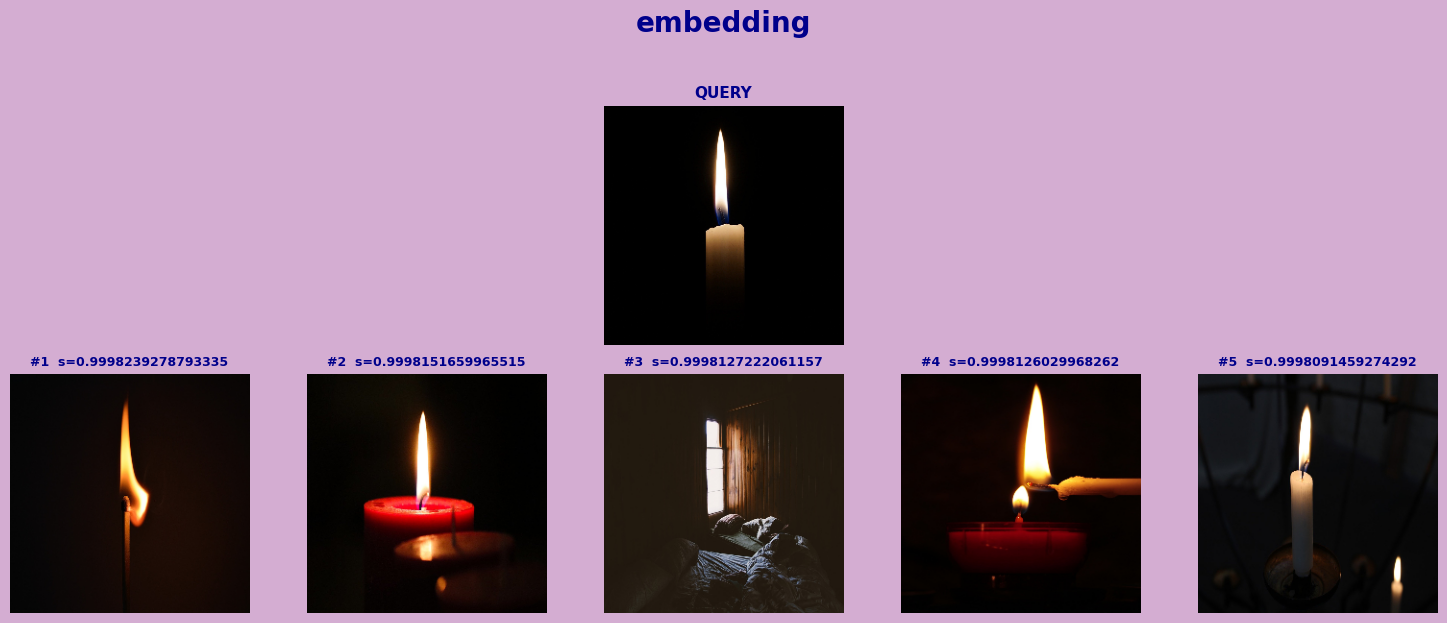

In [ ]:
TOP_K = 5  # Anzahl der Ergebnisse, die angezeigt werden sollen
DB = Path(r"C:\BIG_DATA\data\database.db")
IMG = Path(r"Z:\CODING\UNI\BIG_DATA\data\TEST_IMAGES\Dunkelheit-und-Licht.png")
MODE = "embedding"  # "mix" | "embedding" | "color" | "hash"


cfg = Config(
    mode=MODE,
    top_k=TOP_K,
)
warmup(cfg)

out = search_once(IMG, DB, cfg)


def _read_rgb(path, size):
    if not path or not os.path.exists(path):
        return np.zeros((size[1], size[0], 3), np.uint8)
    data = np.fromfile(path, dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img is None:
        return np.zeros((size[1], size[0], 3), np.uint8)
    img = cv2.resize(img, size)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def show_query_and_results(
    out, cols=5, size=(250, 250), bg="#D4ADD2FF", font="darkblue"
):
    items = list(out["results"]["final_top_k"][:TOP_K])
    qpath = (out.get("query") or {}).get("image_path", None)

    n = len(items)
    rows = max(1, (n + cols - 1) // cols)

    fig_h = (1 + rows) * 3
    fig_w = cols * 3
    fig = plt.figure(figsize=(fig_w, fig_h), facecolor=bg)  # <= Figure-Hintergrund
    gs = fig.add_gridspec(nrows=2, ncols=cols, height_ratios=[1, rows])

    # Query oben (über alle Spalten)
    axq = fig.add_subplot(gs[0, :])
    axq.set_facecolor(bg)  # <= Axes-Hintergrund
    if qpath:
        axq.imshow(_read_rgb(qpath, size))
        axq.set_title("QUERY", fontsize=11, weight="bold", color=font)
    else:
        axq.imshow(np.zeros((size[1], size[0], 3), np.uint8))
        axq.set_title("QUERY (missing)", fontsize=11, weight="bold", color=font)
    axq.axis("off")

    # Ergebnisse unten als Grid
    sub = gs[1, :].subgridspec(rows, cols)
    for i, it in enumerate(items):
        r, c = divmod(i, cols)
        ax = fig.add_subplot(sub[r, c])
        ax.set_facecolor(bg)  # <= Axes-Hintergrund
        path = it.get("image_path") or it.get("path")
        img = _read_rgb(path, size)
        ax.imshow(img)
        score = it.get("score", it.get("score_fused"))
        title = f"#{i+1}  s={score}" if isinstance(score, (int, float)) else f"#{i+1}"
        ax.set_title(title, fontsize=9, color=font, weight="bold")
        ax.axis("off")

    plt.suptitle(f"{MODE}", fontsize=20, weight="bold", y=1.03, color=font)
    plt.tight_layout()
    plt.show()


# Aufruf:
show_query_and_results(out, cols=5)

In [15]:
from importlib import reload
import engine.core as core

reload(core)  # lädt Modul neu; Caches sind wieder leer

# Danach warmup erneut:
warmup(cfg)